In [2]:
import lz4.frame
import polars as pl
from scipy.interpolate import BSpline
from config import columns, split_fractions, int_cols
import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import itertools
import torch
import math

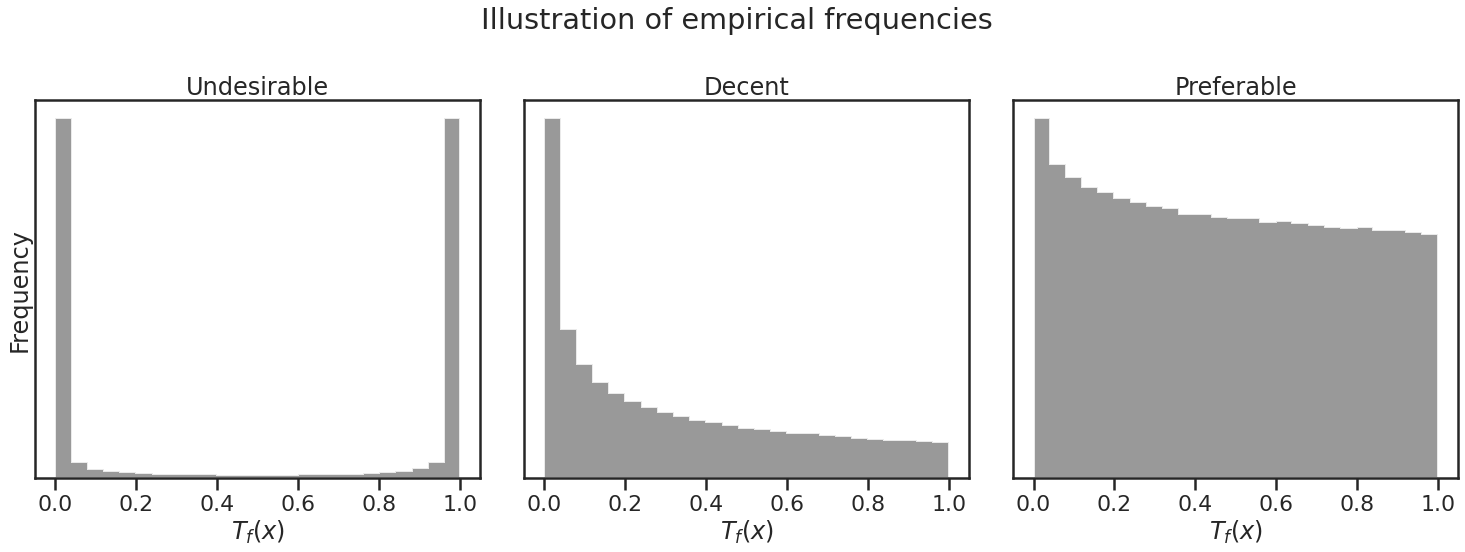

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_context('poster', rc={"lines.linewidth": 8})
sns.set_style("ticks")

fig, axs = plt.subplots(1, 3, figsize=(21, 8))

X = np.tanh(np.random.uniform(-10, 10, size=1000000)) / 2 + 1./2
axs[0].hist(X, bins=25, density=True, histtype='stepfilled', color='gray', alpha=0.8)
axs[0].set_title('Undesirable')
axs[0].tick_params(labelleft=False, left=False)
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('$T_f(x)$')

Y = np.random.uniform(-1, 1, size=1000000) ** 2
axs[1].hist(Y, bins=25, density=True, histtype='stepfilled', color='gray', alpha=0.8)
axs[1].set_title('Decent')
axs[1].tick_params(labelleft=False, left=False)
axs[1].set_xlabel('$T_f(x)$')

Z = np.random.uniform(0, 1, size=1000000) ** 1.1
axs[2].hist(Z, bins=25, density=True, histtype='stepfilled', color='gray', alpha=0.8)
axs[2].set_title('Preferable')
axs[2].tick_params(labelleft=False, left=False)
axs[2].set_xlabel('$T_f(x)$')

fig.suptitle('Illustration of empirical frequencies')
fig.tight_layout()

plt.show()

In [3]:
data_file = 'train.txt.lz4'
with lz4.frame.open(data_file, 'rb') as f:
    df = pl.read_csv(f, separator='\t', has_header=False, new_columns=columns)

/tmp/ipykernel_1543730/3088064557.py:3: UserWarning: Polars found a filename. Ensure you pass a path to the file instead of a python file object when possible for best performance.
  df = pl.read_csv(f, separator='\t', has_header=False, new_columns=columns)


In [4]:
df.head()

label,I_1,I_2,I_3,I_4,I_5,I_6,I_7,I_8,I_9,I_10,I_11,I_12,I_13,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10,C_11,C_12,C_13,C_14,C_15,C_16,C_17,C_18,C_19,C_20,C_21,C_22,C_23,C_24,C_25,C_26
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
0,1,1,5,0,1382,4,15,2,181,1,2,null,2,"""68fd1e64""","""80e26c9b""","""fb936136""","""7b4723c4""","""25c83c98""","""7e0ccccf""","""de7995b8""","""1f89b562""","""a73ee510""","""a8cd5504""","""b2cb9c98""","""37c9c164""","""2824a5f6""","""1adce6ef""","""8ba8b39a""","""891b62e7""","""e5ba7672""","""f54016b9""","""21ddcdc9""","""b1252a9d""","""07b5194c""",null,"""3a171ecb""","""c5c50484""","""e8b83407""","""9727dd16"""
0,2,0,44,1,102,8,2,2,4,1,1,null,4,"""68fd1e64""","""f0cf0024""","""6f67f7e5""","""41274cd7""","""25c83c98""","""fe6b92e5""","""922afcc0""","""0b153874""","""a73ee510""","""2b53e5fb""","""4f1b46f3""","""623049e6""","""d7020589""","""b28479f6""","""e6c5b5cd""","""c92f3b61""","""07c540c4""","""b04e4670""","""21ddcdc9""","""5840adea""","""60f6221e""",null,"""3a171ecb""","""43f13e8b""","""e8b83407""","""731c3655"""
0,2,0,1,14,767,89,4,2,245,1,3,3,45,"""287e684f""","""0a519c5c""","""02cf9876""","""c18be181""","""25c83c98""","""7e0ccccf""","""c78204a1""","""0b153874""","""a73ee510""","""3b08e48b""","""5f5e6091""","""8fe001f4""","""aa655a2f""","""07d13a8f""","""6dc710ed""","""36103458""","""8efede7f""","""3412118d""",null,null,"""e587c466""","""ad3062eb""","""3a171ecb""","""3b183c5c""",null,null
0,null,893,null,null,4392,null,0,0,0,null,0,null,null,"""68fd1e64""","""2c16a946""","""a9a87e68""","""2e17d6f6""","""25c83c98""","""fe6b92e5""","""2e8a689b""","""0b153874""","""a73ee510""","""efea433b""","""e51ddf94""","""a30567ca""","""3516f6e6""","""07d13a8f""","""18231224""","""52b8680f""","""1e88c74f""","""74ef3502""",null,null,"""6b3a5ca6""",null,"""3a171ecb""","""9117a34a""",null,null
0,3,-1,null,0,2,0,3,0,0,1,1,null,0,"""8cf07265""","""ae46a29d""","""c81688bb""","""f922efad""","""25c83c98""","""13718bbd""","""ad9fa255""","""0b153874""","""a73ee510""","""5282c137""","""e5d8af57""","""66a76a26""","""f06c53ac""","""1adce6ef""","""8ff4b403""","""01adbab4""","""1e88c74f""","""26b3c7a7""",null,null,"""21c9516a""",null,"""32c7478e""","""b34f3128""",null,null


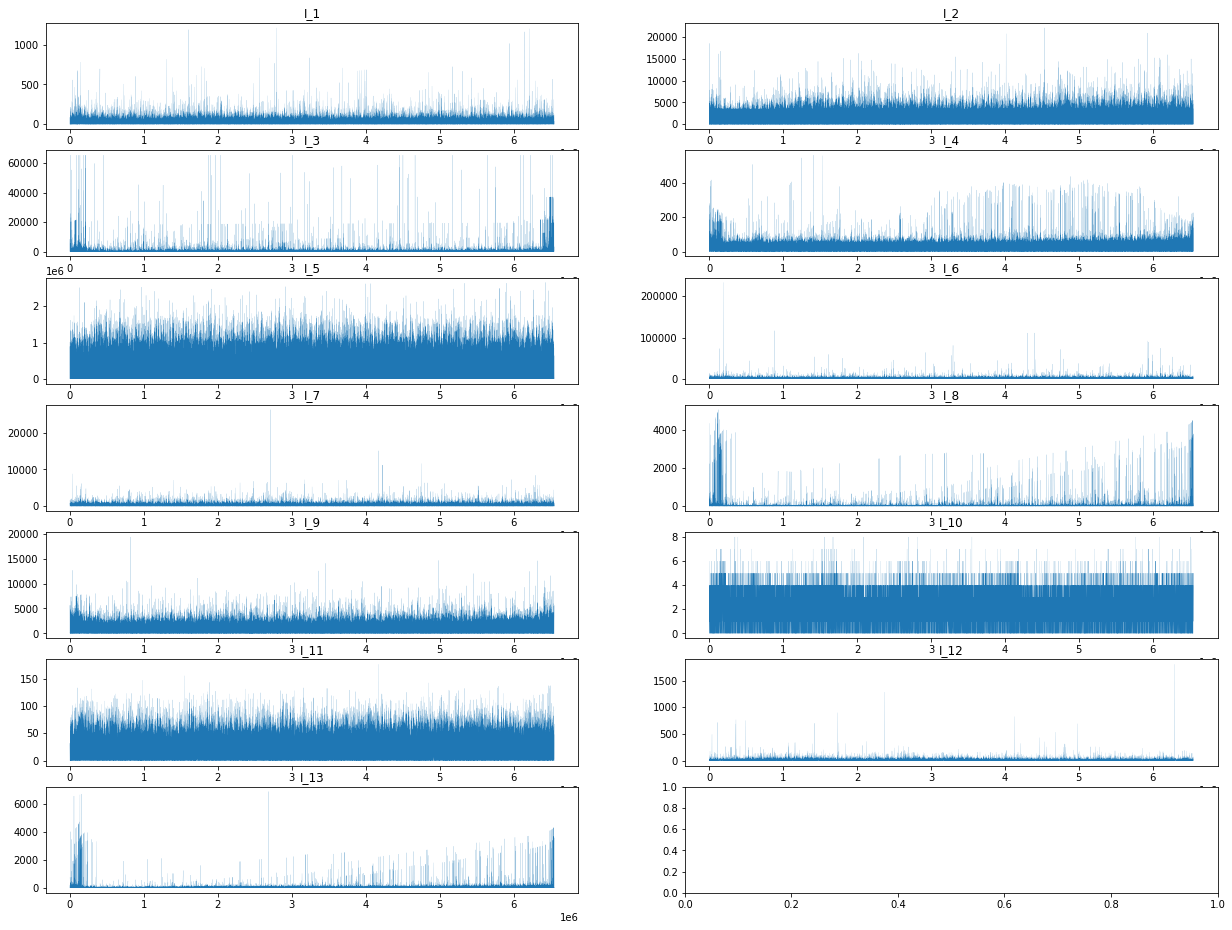

In [14]:
fig, axs = plt.subplots(7, 2, figsize=(21, 16))
pdf = df.head(len(df) // 7)
timeline = np.arange(0, len(pdf))
for ax, col_name in zip(axs.ravel(), int_cols):
    mask = pdf[col_name].is_not_null()
    masked_timeline = timeline[mask.to_numpy()]
    masked_col = pdf[col_name].filter(mask).to_numpy()
    ax.plot(masked_timeline, masked_col, linewidth=0.1)
    ax.set_title(col_name)

In [17]:
split_sizes = np.rint(np.array(split_fractions) * len(df)).astype(np.int32)
split_sizes

array([6548660, 6548660, 6548660], dtype=int32)

In [18]:
train_df = df.head(split_sizes[0])
remain_df = df.tail(-split_sizes[0])
valid_df = remain_df.head(split_sizes[1])
test_df = remain_df.tail(-split_sizes[1])

In [29]:
class IntColumnScaler:
    def __init__(self, at_least=0):
        self.at_least = at_least
        
    def fit(self, col):
        n = len(col)
        self.col_max_ = np.quantile(col, 0.99)
        return self
    
    def transform(self, col):
        col = np.clip(col, a_min=self.at_least, a_max=self.col_max_)
        col = np.square(np.arcsinh(col))
        scale_max = np.square(np.arcsinh(self.col_max_))
        return col / scale_max

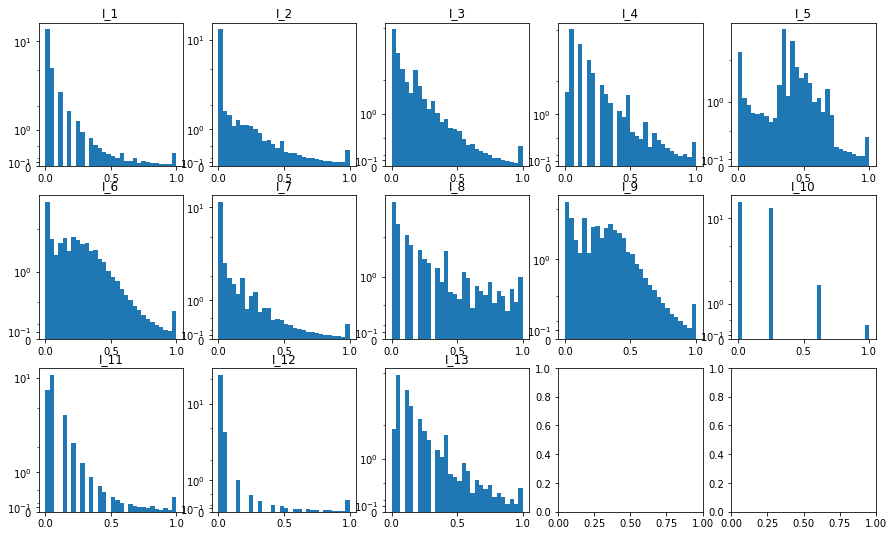

In [30]:
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
for ax, col_name in zip(axs.ravel(), int_cols):
    col = train_df[col_name]
    col = col.filter(col >= 0).to_numpy()
    scaled = IntColumnScaler().fit(col).transform(col)
    ax.hist(scaled, bins=30, density=True)
    ax.set_yscale('asinh')
    ax.set_title(col_name)

In [ ]:
class SplineTransformer:
    def __init__(self, at_least=0, degree=3, n_knots=20):
        self.at_least = 0
        self.scaler = IntColumnScaler(at_least)
        self.degree = degree
        self.knots = np.pad(np.linspace(0, 1, n_knots), degree, 'edge')
    
    def get_discrete_(self, col):
        return col.filter((col < self.at_least) | (col.is_null()))
    
    def get_continuous_mask_(self, col):
        return (col >= self.at_least).fill_null(False)

    def get_continuous_(self, col):
        return col.filter(col >= self.at_least)
    
    def fit(self, col):
        self.discrete_keys_ = self.get_discrete_(col).extend_constant(None, 1).unique().to_list()
        self.discrete_values_ = list(range(len(self.discrete_keys_)))
        self.n_discrete_ = len(self.discrete_keys_)
        self.scaler.fit(self.get_continuous_(col))  
        return self
    
    def transform(self, col):
        discrete = self.get_discrete_(col).replace_strict(
            old=self.discrete_keys_, 
            new=self.discrete_values_,
            default=0)
        discrete = torch.as_tensor(discrete.to_numpy()).to(torch.int32)
        
        scaled = self.scaler.transform(self.get_continuous_(col).to_numpy())
        spline_basis = BSpline.design_matrix(scaled, self.knots, self.degree) \
            .astype(np.float32)
        spline_indices = torch.tensor(spline_basis.indices.reshape(-1, 1 + self.degree))
        spline_weights = torch.tensor(spline_basis.data.reshape(-1, 1 + self.degree))
        
        indices = torch.zeros(len(col), spline_weights.shape[1], dtype=torch.int32)
        weights = torch.zeros(len(col), spline_weights.shape[1], dtype=torch.float32)
        continuous_mask = torch.as_tensor(self.get_continuous_mask_(col).to_numpy(writable=True))
        
        indices.masked_scatter_(continuous_mask[:, None], spline_indices + self.n_discrete_)
        weights.masked_scatter_(continuous_mask[:, None], spline_weights)
        indices.select(-1, 0).masked_scatter_(~continuous_mask, discrete)
        weights.select(-1, 0).masked_fill_(~continuous_mask, 1.)
        
        return indices, weights, (len(self.discrete_keys_) + len(self.knots) - self.degree + 1)

In [195]:
class IntTransformer:
    def fit(self, col):
        max_val = col.max()
        self.max_bin_ = int(math.floor(math.log(max_val) ** 2))
        self.min_ = col.min()
        return self
    
    def transform(self, col):
        pos_mask = (col > 0).fill_null(False)
        neg_mask = (col <= 0).fill_null(False)
        
        pos = col.filter(pos_mask).to_numpy()
        pos_bins = np.floor(np.square(np.log(pos))).astype(np.int32)
        pos_bins = 1 + np.clip(pos_bins, a_min=None, a_max=self.max_bin_) - self.min_
        
        neg = col.filter(neg_mask).to_numpy().astype(np.int32)
        neg_bins = 1 + np.clip(neg, a_min=self.min_, a_max=None) - self.min_
        
        pos_mask = torch.as_tensor(pos_mask.to_numpy())
        neg_mask = torch.as_tensor(neg_mask.to_numpy())
        pos_bins = torch.as_tensor(pos_bins)
        neg_bins = torch.as_tensor(neg_bins)
        
        indices = torch.zeros(len(col), dtype=torch.int32)
        indices.masked_scatter_(pos_mask, pos_bins)
        indices.masked_scatter_(neg_mask, neg_bins)
        indices = indices.reshape(-1, 1)
        weights = torch.ones(len(col), 1, dtype=torch.float32)

        return indices, weights, (2 + self.max_bin_ - self.min_)

In [228]:
class CatTransformer:
    infrequent = 'INFREQUENT'
    na = 'MISSING'

    def __init__(self, min_frequency=10):
        self.min_frequency = min_frequency

    def fit(self, col):
        col = col.fill_null(self.na)
        vcs = col.value_counts()
        frequent = vcs.filter(pl.col('count') >= self.min_frequency)[col.name]
        self.frequent_cats_ = list(set(frequent) | {self.infrequent, self.na})
        self.frequent_cat_idx_ = list(range(len(self.frequent_cats_)))
        return self

    def transform(self, col):
        col = col.fill_null(self.na)
        col[~col.is_in(self.frequent_cats_)] = self.infrequent
        ordinal = col.replace_strict(self.frequent_cats_, self.frequent_cat_idx_)
        
        indices = torch.as_tensor(ordinal.to_numpy().astype(np.int32)).reshape(-1, 1)
        weights = torch.ones(len(col), 1, dtype=torch.float32)
        cnt = len(self.frequent_cats_)
        return indices, weights, cnt